# 📊 Smart City Traffic Forecasting (Professional Version)
Includes EDA, Prophet, ARIMA, XGBoost. Prepared for portfolio and professional use.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('traffic.csv')
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['hour'] = df['DateTime'].dt.hour
df['day'] = df['DateTime'].dt.day
df['weekday'] = df['DateTime'].dt.weekday
df['month'] = df['DateTime'].dt.month
df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
df = df.sort_values('DateTime')
df['lag_1h'] = df.groupby('Junction')['Vehicles'].shift(1)
df['lag_3h'] = df.groupby('Junction')['Vehicles'].shift(3)
df['lag_6h'] = df.groupby('Junction')['Vehicles'].shift(6)
df['rolling_mean_3h'] = df.groupby('Junction')['Vehicles'].shift(1).rolling(3).mean().reset_index(0, drop=True)
df['rolling_mean_6h'] = df.groupby('Junction')['Vehicles'].shift(1).rolling(6).mean().reset_index(0, drop=True)
df.dropna(inplace=True)
df.head()

,DateTime,Junction,Vehicles,hour,day,weekday,month,is_weekend,lag_1h,lag_3h,lag_6h,rolling_mean_3h,rolling_mean_6h
3006,2020-01-01 06:00:00,4,56,6,1,2,1,0,52.0,44.0,61.0,42.666667,47.500000
1006,2020-01-01 06:00:00,2,60,6,1,2,1,0,48.0,59.0,52.0,46.666667,49.333333
2006,2020-01-01 06:00:00,3,48,6,1,2,1,0,47.0,49.0,38.0,46.000000,44.000000
3007,2020-01-01 07:00:00,4,52,7,1,2,1,0,56.0,45.0,50.0,47.000000,51.000000
1007,2020-01-01 07:00:00,2,42,7,1,2,1,0,60.0,38.0,59.0,44.333333,48.833333


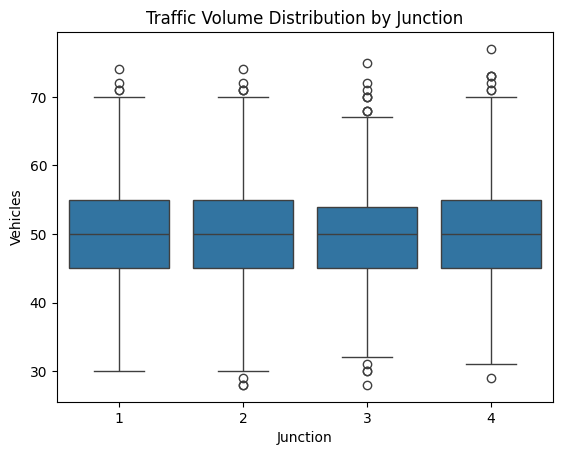

In [4]:
sns.boxplot(x='Junction', y='Vehicles', data=df)
plt.title('Traffic Volume Distribution by Junction')
plt.show()

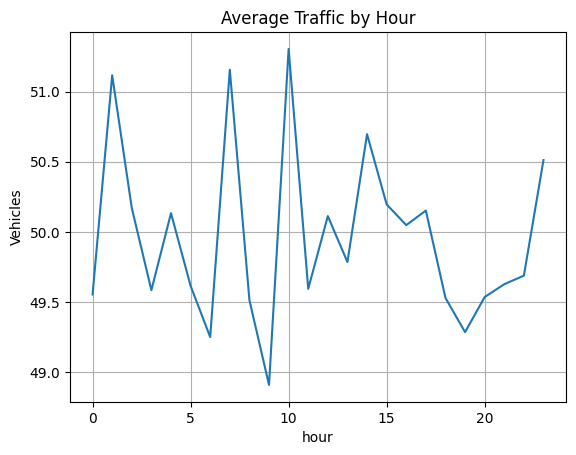

In [5]:
sns.lineplot(data=df.groupby('hour')['Vehicles'].mean())
plt.title('Average Traffic by Hour')
plt.grid()
plt.show()

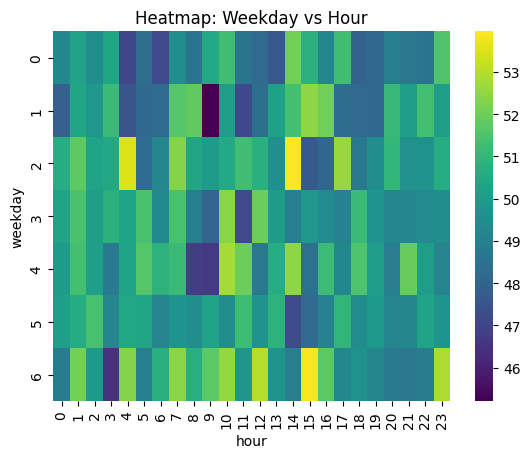

In [6]:
pivot = df.pivot_table(index='weekday', columns='hour', values='Vehicles', aggfunc='mean')
sns.heatmap(pivot, cmap='viridis')
plt.title('Heatmap: Weekday vs Hour')
plt.show()

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d9nic3_/i8g2j4au.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp0d9nic3_/jct5um1k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23082', 'data', 'file=/tmp/tmp0d9nic3_/i8g2j4au.json', 'init=/tmp/tmp0d9nic3_/jct5um1k.json', 'output', 'file=/tmp/tmp0d9nic3_/prophet_modeli6wwykru/prophet_model-20250719144600.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:46:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:46:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


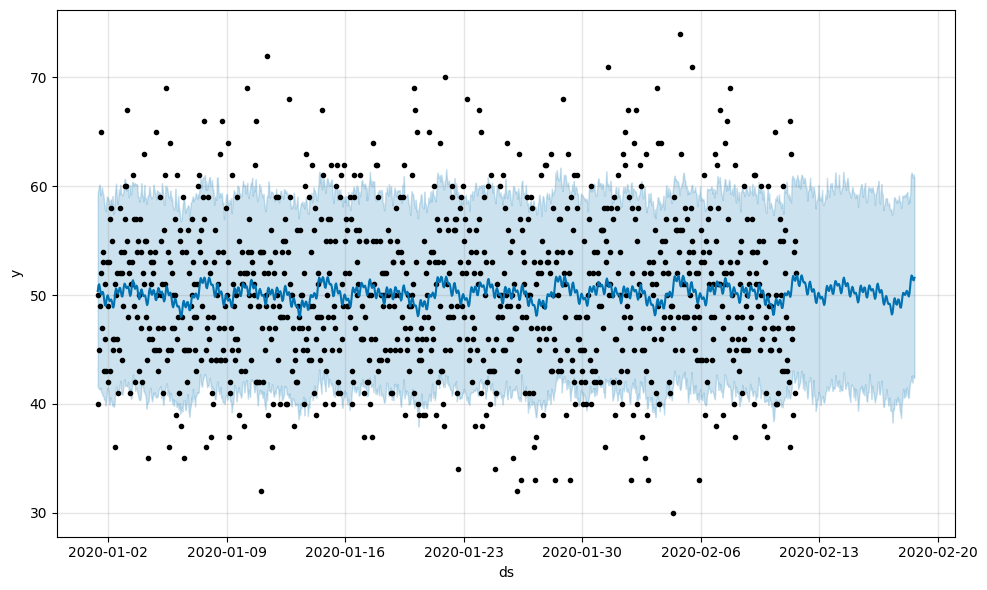

In [7]:
from prophet import Prophet

junction_1 = df[df['Junction'] == 1][['DateTime', 'Vehicles']].rename(columns={'DateTime':'ds', 'Vehicles':'y'})
model = Prophet()
model.fit(junction_1)
future = model.make_future_dataframe(periods=168, freq='H')
forecast = model.predict(future)
model.plot(forecast);

In [8]:
from statsmodels.tsa.arima.model import ARIMA

ts = df[df['Junction'] == 1].set_index('DateTime')['Vehicles']
model_arima = ARIMA(ts, order=(2,1,2)).fit()
forecast_arima = model_arima.forecast(steps=24)
print(forecast_arima)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


2020-02-11 16:00:00    50.307494
2020-02-11 17:00:00    50.111146
2020-02-11 18:00:00    50.206533
2020-02-11 19:00:00    50.105900
2020-02-11 20:00:00    50.206110
2020-02-11 21:00:00    50.106021
2020-02-11 22:00:00    50.205974
2020-02-11 23:00:00    50.106156
2020-02-12 00:00:00    50.205838
2020-02-12 01:00:00    50.106291
2020-02-12 02:00:00    50.205703
2020-02-12 03:00:00    50.106426
2020-02-12 04:00:00    50.205569
2020-02-12 05:00:00    50.106560
2020-02-12 06:00:00    50.205435
2020-02-12 07:00:00    50.106694
2020-02-12 08:00:00    50.205301
2020-02-12 09:00:00    50.106828
2020-02-12 10:00:00    50.205168
2020-02-12 11:00:00    50.106961
2020-02-12 12:00:00    50.205035
2020-02-12 13:00:00    50.107094
2020-02-12 14:00:00    50.204902
2020-02-12 15:00:00    50.107226
Freq: h, Name: predicted_mean, dtype: float64


In [9]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

features = ['hour','day','weekday','month','is_weekend','lag_1h','lag_3h','lag_6h','rolling_mean_3h','rolling_mean_6h']
X = df[features]
y = df['Vehicles']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
model_xgb = XGBRegressor(n_estimators=100)
model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)
print(f'MAE: {mean_absolute_error(y_test, y_pred):.2f}')
print(f'R²: {r2_score(y_test, y_pred):.2f}')

MAE: 6.55
R²: -0.24
